 This file is created so that it can be run interactively using vscode or pycharm.
 It is possible to run this whole file as a script as well.
 Using the `Python: Export Current Python File as Jupyter Notebook` on the command palette,
 this `.py` file can be converted into a jupyter noteobok.
# Introduction
# Methodology
 Data was scraped from [NMC](nmc.org.np) website using python (request, beautifulsoup).
 Then it was added to a sqlite database. The insert technique used  `concurrent.futures`
 for multithreading (to parallelize the write to the database).
 This analysis is written on a notebook style interactive document.
 It uses pandas for data manupulation and plotting
# Analysis
 Men outnumber women in medical profession in Nepal. If divided between different practices (degrees),
 except for  BDS, the dental professionals, women outnumber men.
 In MBBS, a general practice doctor, and MD, specialized practice, men outnumber
 more than 2:1
 Almost a third (7k+) of the total doctors call Kathmandu Valley (Kathmandu, Bhaktapur, Lalitpur)
 About 118 of them did not have a location listed whereas another 117 or so
 did not have district name listed (abbreviated, house number, city/locality, etc.)

In [1]:
# import libraries
import pandas as pd
import sqlite3

# connect to sqlite
from numpy import int64

with sqlite3.connect("nmc.db") as conn:
    doctors = pd.read_sql("select * from doctors", conn)


In [2]:

total_doctors = len(doctors)

print(f'There are {total_doctors} doctors registered through Nepal Medical Council')


There are 20086 doctors registered through Nepal Medical Council


In [3]:

# first 5 rows of data
print(doctors.head())

# dimension of the dataframe
print(doctors.shape)

# describes the summary statistics of numeric columms
print(doctors.describe())

# column names in the dataframe
print(doctors.columns)

# data type in each columns
print(doctors.dtypes)


full_name  nmc_number  \
0            Dr. Kanti Giri (Rai)          20   
1         Dr. Jishnu Prasad Rijal           1   
2  Dr. Sudhir Chandra Chakrawarti           3   
3    Dr. Birendra Bahadur Basnyat          17   
4      Dr. Bishnu Prasad Rajaurai           9   

                               location  gender degree  
0  JYOTI SADAN,3/302 Puhowkl , Lalitpur  Female   MBBS  
1                  Biratnagar , Morang,    Male   MBBS  
2                              Birgunj,    Male   MBBS  
3                   Thamel , Kathmandu,    Male   MBBS  
4                  Syuraj , Kapilvastu,    Male   MBBS  
(20086, 5)
         nmc_number
count  20086.000000
mean   10336.778403
std     5809.374353
min        1.000000
25%     5320.250000
50%    10342.500000
75%    15364.750000
max    20387.000000
Index(['full_name', 'nmc_number', 'location', 'gender', 'degree'], dtype='object')
full_name     object
nmc_number     int64
location      object
gender        object
degree        object
dtype: o

In [4]:
doctors.describe(include=[object])


,full_name,location,gender,degree
count,20086,20086,20086,20086
unique,18375,6209,3,4
top,Dr. Ashish Shrestha,"Kathmandu,",Male,MBBS
freq,12,1525,13239,16550


In [5]:

# Nepal recognizes third gender

print(doctors.gender.value_counts())
print(doctors['degree'].value_counts())


Male      13239
Female     6845
N/A           2
Name: gender, dtype: int64
MBBS    16550
BDS      2093
MD       1441
            2
Name: degree, dtype: int64


In [6]:
doctors.set_index('nmc_number', inplace=True)

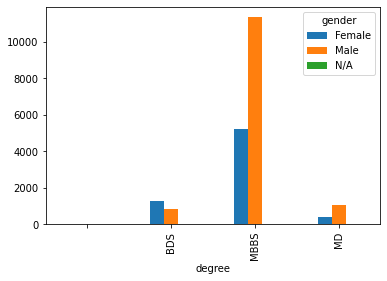

In [7]:
# plotting
doctors.groupby(['gender',"degree"])['gender'].count().unstack(0).plot(kind='bar')

 Additional ideas for analysis
 - Location based analysis. What locations they come from
   - we can take out the districts maybe?
 - Name based analysis
   - Frequent first names
   - Frequent last names
   - Match last name with caste/ ethnicity, etc?

In [8]:
# location based analysis

clean = lambda x: str(x).strip(',. \n\t').replace(" ","").lower().split()

doctors['district'] = doctors['location'].\
    apply(lambda x: x.strip(',.!? \n\t').lower().split(',')[-1].strip())


In [9]:
# counts = pd.DataFrame(doctors['location'].\
#     apply(lambda x: x.strip(',.!? \n\t').lower().split(',')[-1].strip()).\
#         value_counts())


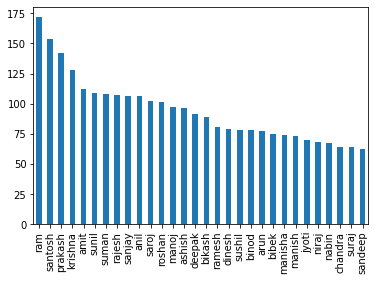

In [10]:
# name based analyses

doctors['full_name'].\
    apply(lambda x: x.lower().replace('dr. ','').split()[0]).\
        value_counts().head(30).\
            plot(kind = 'bar')


 Next, try to analyze the demographic mix of doctors based on caste.
 While we do not have caste listed on our data, Nepali surname is a pretty
 good indicator of their caste. While some surnames are shared over multile castes/ethnicities,
 we will not dive into the details. This is a mere attempt at trying to see if such join is possible.
 The joined data is from the internet, so I cannot comment on it, but it looked complete (ish) and accurate (ish)
 from my novice eyes

In [11]:
doctors['last_name'] = doctors['full_name'].\
    apply(lambda x: x.lower().replace('dr. ','').split()[-1])

In [12]:
# trying to convert caste.txt into a legible dataframe

with open('caste.txt', 'r') as caste:
    next(caste)
    next(caste)
    caste = caste.readlines()
    # with open('writecaste.csv','w') as writefile:
    clean_cast =[line.strip().split(".")[1].strip().lower().split('>', maxsplit=3)
                for line in caste]
                     


In [13]:
caste_df = pd.DataFrame(clean_cast, columns= None)
caste_cols = ['surname', 'caste_ethnicity', 'subclass', 'extra']
caste_df.columns = caste_cols
caste_df['surname']= caste_df['surname'].str.strip()
caste_df.iloc[:,0] = caste_df.iloc[:,0].str.strip()
print(caste_df.head())



surname  caste_ethnicity  \
0    acharya           bahun    
1    acharya   newar-brahman    
2   adhikari           bahun    
3  agnihotri   newar-brahman    
4       agri            magar   

                                          subclass extra  
0                               kaudinya (purbiya)  None  
1                   rajopadhyaya devabhaju brahman  None  
2   kashyap, bharadwaj, atreya, mandabya (purbiya)  None  
3                   rajopadhyaya devabhaju brahman  None  
4                                             None  None  


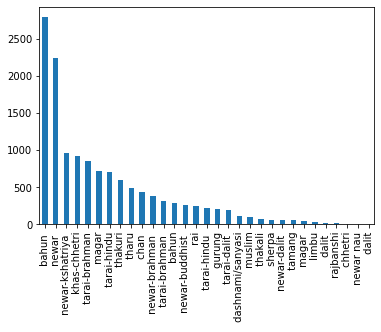

In [14]:
merged_doctors = doctors.merge(caste_df.drop_duplicates(\
    subset='surname',keep='last'),\
         left_on='last_name', right_on='surname')

merged_doctors.caste_ethnicity.value_counts().plot(kind ='bar')
